<a href="https://colab.research.google.com/github/PMartey/KaggleX-Project/blob/main/Stock_trading_and_Insurance_Bot_KaggleX_QA_with_Gemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# Download the gemma_2b_en/2 from kaggle

keras_gemma_keras_gemma_2b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_2b_en/2')
#keras_gemma_keras_gemma_instruct_2b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_instruct_2b_en/2')
#keras_gemma_keras_gemma_instruct_7b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_instruct_7b_en/2')
#keras_gemma_keras_gemma_7b_en_2_path = kagglehub.model_download('keras/gemma/Keras/gemma_7b_en/2')

print('Data source import complete.')

Data source import complete.


# Google – AI Assistants for Data Tasks with Gemma with [KerasNLP](https://github.com/keras-team/keras-nlp) and [Keras](https://github.com/keras-team/keras)

> The objective of this question and answer model is to build a chatbot to assist individuals in understanding stock trading concepts or answering day to day insurance or stock trading questions

<div align="center">
    <img src="https://thumbs.dreamstime.com/z/financial-money-business-diagram-report-52108082.jpg?ct=jpeg">
</div>

In this project, we will create a notebook that demonstrate how to use the Gemma LLM to accomplish one or more of the following  tasks:
1. **<font color="red">Answer common questions about insurance or trades.</font>**
2. Explain or teach basic trading/insurance concepts.
3. Summarize Solution write-ups.
4. Give insurance market estimates.
5. Answer common questions about what is going on in the stock market.

This notebook guides you through performing `"1. Answer common questions about insurance or trades"` task for the project. As this task requires specific knowledge of the financial markets(banking,stocks,insurance,and shares), we need precise information about Finance. To do so, I have created a dataset, ["Final Training Dataset"], collecting data from [huggingface.com](https://huggingface.co/datasets/yymYYM/stock_trading_QA). To make things easier for the model, the data is curated to have Question-Answer pair format. We will use this dataset to fine-tune **Gemma LLM** to answer questions about stcok trading.

<u>Fun fact</u>: This notebook is backend-agnostic, supporting TensorFlow, PyTorch, and JAX. However, the best performance can be achieved from `JAX`. Utilizing KerasNLP and Keras allows us to choose our preferred backend. Explore more details on [Keras](https://keras.io/keras_3/).

**Note**: For a more in-depth understanding of KerasNLP, refer to the [KerasNLP guides](https://keras.io/keras_nlp/).

# Install Libraries

In [ ]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


# Import Libraries

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00" # avoid memory fragmentation on JAX backend.

import keras
import keras_nlp

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas() # progress bar for pandas

import plotly.graph_objs as go
import plotly.express as px
from IPython.display import display, Markdown

# Configuration

In [ ]:
class CFG:
    seed = 42
    dataset_path = "/content/train1_data.csv"
    preset = "gemma_2b_en" # name of pretrained Gemma #using this instead 'gemma_instruct_2b_en' of 'gemma_2b_en'
    sequence_length = 512 # max size of input sequence for training
    batch_size = 1 # size of the input batch in training, x 2 as two GPUs
    epochs = 30 # number of epochs to train

# Reproducibility
Sets value for random seed to produce similar result in each run.

In [ ]:
keras.utils.set_random_seed(CFG.seed)

# Data

The newly created **STand I-questions-and-answers** dataset contains only approximately $198$ question-answer pairs curated from raw data from the `huggingface.com` website. However, one can create many more samples from this provided data through simple augmentation or prompt engineering.  In this notebook, we will focus on keeping it simple.

**Data Format:**

- The question-answer pair data is stored in `/kaggle/input/provide link` file.
- This file includes:
    - `Question`: A question about banking,stocks, insurance, and shares
    - `Answer`: Answer to the question in markdown format
    
> You can access the **raw** data from `hugging face`, where there are `.parquet and .csv` files for each of the **two** categories.

In [ ]:
df_train = pd.read_csv(f"{CFG.dataset_path}")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  198 non-null    object
 1   answer    198 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [ ]:
# Randomly select 250 rows from my data set since training on all 12047 rows takes more storage
df = df_train.sample(n=100, random_state=42)
print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 65 to 144
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  100 non-null    object
 1   answer    100 non-null    object
dtypes: object(2)
memory usage: 2.3+ KB
None


,question,answer
65,How can one purchase LIC Bima Jyoti?,LIC Bima Jyoti can be purchased both online an...
114,"Where can I find specific information, like pr...","Specific information, such as premium due date..."


We'll use the following simple template to create prompts from question-answer pairs and category to feed text into the model:

```

Question: ...

Answer: ...
```

This template helps the model understand what you're asking and how to respond accurately. You can explore more advanced prompt templates for better results.

In [ ]:
template = "\n\nQuestion:\nUser-{Question}\n\nAnswer:\n{Answer}"

In [ ]:
df["prompt"] = df.progress_apply(lambda row: template.format(
                                                             Question=row.question,
                                                             Answer=row.answer), axis=1)
data = df.prompt.tolist()


  0%|          | 0/100 [00:00<?, ?it/s]

Let's examine a sample prompt. As the answers in our dataset are curated with **markdown** format, we will render the sample using `Markdown()` to properly visualize the formatting.

## Sample

In [ ]:
def colorize_text(text):
    for word, color in zip(["Question", "Answer"], ["red", "green"]):
        text = text.replace(f"\n\n{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

In [ ]:
# Take a random sample
sample = data[45]

# Give colors to Question, Answer and Category
sample = colorize_text(sample)

# Show sample in markdown
display(Markdown(sample))  # this is an incomplete answer



**<font color='red'>Question:</font>**
User-What if I lose my policy document?

**<font color='green'>Answer:</font>**
In case of a lost policy document, policyholders should immediately inform LIC and file a written request for a duplicate policy. The request should include details like the policy number, holders name, and a brief explanation of the loss. After verification, LIC will issue a duplicate policy document. Policyholders may need to pay a nominal fee for the duplicate copy. Contacting the nearest LIC branch or using online services can facilitate the process.

## Word Cloud
Let's do a simple EDA to determine the most common areas of questions asked.

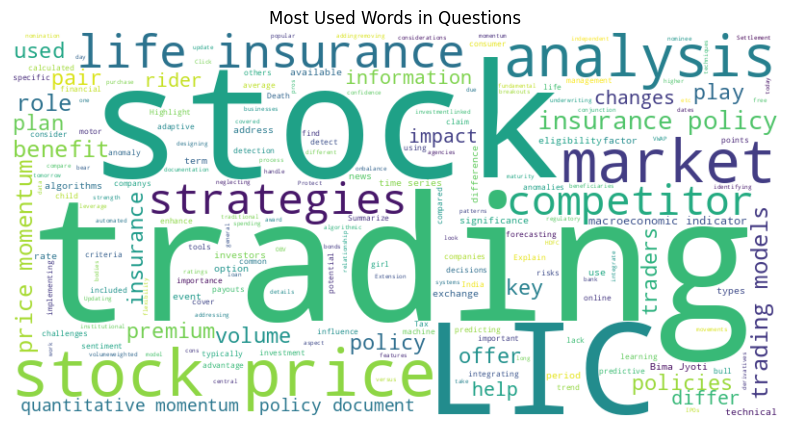

In [ ]:
# Create a word cloud for my most asked questions
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#join all the real news
question_tags = ' '.join(list(df['question']))

# create word cloud for real news
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(question_tags)

# plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Used Words in Questions')
plt.show()

# Modeling

## Gemma Casual LM

In [ ]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

## Gemma LM Preprocessor

In [ ]:
x, y, sample_weight = gemma_lm.preprocessor(data[0:1])

This preprocessing layer will take in batches of strings, and return outputs in a `(x, y, sample_weight)` format, where the `y` label is the next token id in the `x` sequence.

From the code below, we can see that, after the preprocessor, the data shape is `(num_samples, sequence_length)`.

In [ ]:
# Display the shape of each processed output
for k, v in x.items():
    print(k, ":", v.shape)

token_ids : (1, 1024)
padding_mask : (1, 1024)


# Inference before fine tuning

Let's ask the Gemma model some sample questions using our prepared prompt and see how it responds.

> As this model is not tuned for instruction yet, you will notice that the model is creating more question-answer pairs instead of answering the question that was asked.

## Sample 1

In [ ]:
# Take one sample
row = df.iloc[2]

# Generate Prompt using template
prompt = template.format(
   # Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-What role does consumer confidence play in stock trading models?

**<font color='green'>Answer:</font>**
Consumer confidence is a key factor in stock trading models. It is a measure of how confident consumers are in the economy and their ability to make money. When consumer confidence is high, people are more likely to spend money and invest in stocks. This can lead to an increase in demand for stocks, which can drive up their prices. Conversely, when consumer confidence is low, people are less likely to spend money and invest in stocks, which can lead to a decrease in demand and lower stock prices.

**<font color='red'>Question:</font>**
User-What are some of the factors that can affect consumer confidence?

**<font color='green'>Answer:</font>**
There are a number of factors that can affect consumer confidence. These include economic conditions, political events, and personal circumstances. For example, if the economy is doing well and people are feeling confident about their financial future, they may be more likely to spend money and invest in stocks. On the other hand, if the economy is struggling and people are feeling uncertain about their financial future, they may be less likely to spend money and invest in stocks.

**<font color='red'>Question:</font>**
User-How can consumer confidence be measured?

**<font color='green'>Answer:</font>**
Consumer confidence can be measured in a

## Sample 2

In [ ]:
# Take one sample
row = df.iloc[45]

# Generate Prompt using template
prompt = template.format(
   # Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))  # This response does not add up



**<font color='red'>Question:</font>**
User-What if I lose my policy document?

**<font color='green'>Answer:</font>**
User-I will have to contact the insurance company and request a copy of the policy.

**<font color='red'>Question:</font>**
User-What if I have a question about my policy?

**<font color='green'>Answer:</font>**
User-I will have to contact the insurance company and request a copy of the policy.

**<font color='red'>Question:</font>**
User-What if I need to make a change to my policy?

**<font color='green'>Answer:</font>**
User-I will have to contact the insurance company and request a copy of the policy.

**<font color='red'>Question:</font>**
User-What if I need to cancel my policy?

**<font color='green'>Answer:</font>**
User-I will have to contact the insurance company and request a copy of the policy.

**<font color='red'>Question:</font>**
User-What if I need to make a claim?

**<font color='green'>Answer:</font>**
User-I will have to contact the insurance company and request a copy of the policy.

**<font color='red'>Question:</font>**
User-What if I need to file a complaint?

**<font color='green'>Answer:</font>**
User-I will have to contact the insurance company and request a copy of the policy.

**<font color='red'>Question:</font>**
User-What if I need to file a lawsuit?

**<font color='green'>Answer:</font>**
User-I will have to contact the insurance company and

# Fine-tuning with LoRA

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 10.
gemma_lm.backbone.enable_lora(rank=10)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,509,582,336 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,509,582,336 (9.35 GB)

 Trainable params: 3,409,920 (13.01 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

**Notice** that, the number of trainable parameters is reduced from ~$2.5$ billions to ~$3.4$ millions after enabling LoRA.

## Training

In [ ]:

# Limit the input sequence length to 512 (to control memory usage).
gemma_lm.preprocessor.sequence_length = CFG.sequence_length

import tensorflow as tf

# Set up a learning rate schedule with a warm-up phase
initial_learning_rate = 8e-5
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)


# Compile the model with loss, optimizer, and metric
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Add checkpoint callback
#checkpoint = ModelCheckpoint(
    #filepath='best_gemma_model.keras',
    #monitor='val_loss',
    #save_best_only=True,
    #mode='min',
    #save_weights_only=False,
    #verbose=1
#)

# Train the model
gemma_lm.fit(
    data,
    epochs=CFG.epochs,
    batch_size=CFG.batch_size,
    #validation_data= df_val,
    #validation_split= 0.2,  # Use 20% of the data for validation
    #callbacks=[checkpoint]
)


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 0.4487 - sparse_categorical_accuracy: 0.4910
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 0.3589 - sparse_categorical_accuracy: 0.5619
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - loss: 0.3293 - sparse_categorical_accuracy: 0.5774
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - loss: 0.3084 - sparse_categorical_accuracy: 0.5991
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - loss: 0.2927 - sparse_categorical_accuracy: 0.6118
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - loss: 0.2800 - sparse_categorical_accuracy: 0.6225
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - loss: 0.2697 - sparse_categorical_accuracy: 0.6373
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - loss: 0.2623 - sparse_categorical_accuracy: 0.6461
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - loss: 0.2581 - sparse_categorical_accuracy: 0.6529
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 136s 

# Inference after fine-tuning

Let's see how our fine-tuned model responds to the same questions we asked before fine-tuning the model.

## Sample 1

In [ ]:
# Take one sample
row = df.iloc[2]

# Generate Prompt using template
prompt = template.format(
   # Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-What role does consumer confidence play in stock trading models?

**<font color='green'>Answer:</font>**
Consumer confidence reflects the sentiment of consumers towards the economy. A high level of consumer confidence can indicate increased spending and potentially higher stock prices.

## Sample 2

In [ ]:
# Take one sample
row = df.iloc[45]

# Generate Prompt using template
prompt = template.format(
    #Category=row.Category,
    Question=row.question,
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-What if I lose my policy document?

**<font color='green'>Answer:</font>**
In case of a lost policy document, policyholders should immediately inform LIC and file a written request for a duplicate policy. The request should include details like the policy number, holders name, and a brief explanation of the loss. After verification, LIC will issue a duplicate policy document. Policyholders can then contact LIC for assistance in safely securing the duplicate policy or use digital copies.

## Unseen Sample

Also just for fun, let's try out a question that model hasn't seen during training.

In [ ]:
# Generate Prompt using template
prompt = template.format(
    #Category="kaggle-notebook",
    Question="When is a good time to enter a trade",
    Answer=""
)

# Infer
output = gemma_lm.generate(prompt, max_length=256)

# Colorize
output = colorize_text(output)

# Display in markdown
display(Markdown(output))



**<font color='red'>Question:</font>**
User-When is a good time to enter a trade

**<font color='green'>Answer:</font>**
A good time to enter a trade is when the fundamentals support the prediction of a rising price trend. Consider evaluating key indicators, technical patterns, and relevant moving averages to determine if a move is imminent and if a potential buy or sell opportunity exists.

In [ ]:
# Save my model as a preset
!mkdir STIbot_my_gemma2_pt # Create the directory
gemma_lm.save_to_preset(f"./STIbot_my_gemma2_pt") # Save the model to the directory as a preset

# Upload the model to Kaggle
my_user_name = "dedemartey"
my_model_name = "STIbot_my_gemma2_pt"
kaggle_uri = f"kaggle://{my_user_name}/gemma/keras/{my_model_name}"
keras_nlp.upload_preset(kaggle_uri, f"./{my_model_name}")

Uploading Model https://www.kaggle.com/models/dedemartey/gemma/keras/STIbot_my_gemma2_pt ...
Starting upload for file ./STIbot_my_gemma2_pt/config.json


Uploading: 100%|██████████| 785/785 [00:00<00:00, 1.21kB/s]

Upload successful: ./STIbot_my_gemma2_pt/config.json (785B)
Starting upload for file ./STIbot_my_gemma2_pt/tokenizer.json



Uploading: 100%|██████████| 591/591 [00:00<00:00, 957B/s]

Upload successful: ./STIbot_my_gemma2_pt/tokenizer.json (591B)
Starting upload for file ./STIbot_my_gemma2_pt/model.weights.h5



Uploading: 100%|██████████| 10.0G/10.0G [02:44<00:00, 60.9MB/s]

Upload successful: ./STIbot_my_gemma2_pt/model.weights.h5 (9GB)
Starting upload for file ./STIbot_my_gemma2_pt/preprocessor.json



Uploading: 100%|██████████| 1.41k/1.41k [00:00<00:00, 2.34kB/s]

Upload successful: ./STIbot_my_gemma2_pt/preprocessor.json (1KB)
Starting upload for file ./STIbot_my_gemma2_pt/metadata.json



Uploading: 100%|██████████| 143/143 [00:00<00:00, 221B/s]

Upload successful: ./STIbot_my_gemma2_pt/metadata.json (143B)
Starting upload for file ./STIbot_my_gemma2_pt/task.json



Uploading: 100%|██████████| 2.98k/2.98k [00:00<00:00, 5.11kB/s]

Upload successful: ./STIbot_my_gemma2_pt/task.json (3KB)
Starting upload for file ./STIbot_my_gemma2_pt/assets/tokenizer/vocabulary.spm



Uploading: 100%|██████████| 4.24M/4.24M [00:00<00:00, 5.68MB/s]

Upload successful: ./STIbot_my_gemma2_pt/assets/tokenizer/vocabulary.spm (4MB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/dedemartey/gemma/keras/STIbot_my_gemma2_pt


In [ ]:
# Upload model to hugging face to
my_user_name = "Dede29"
my_model_name = "STIbot_my_gemma2_pt"